In [1]:
!wget -O moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o moviedataset.zip -d ./data
!unzip -o moviedataset.zip -d ./data

--2019-04-16 17:02:01--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org... 128.101.34.235
Connecting to files.grouplens.org|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: 'moviedataset.zip'

moviedataset.zip    100%[=====================>]   5.64M  2.73MB/s   in 2.1s   

2019-04-16 17:02:04 (2.73 MB/s) - 'moviedataset.zip' saved [5917549/5917549]

Archive:  moviedataset.zip
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  
Archive:  moviedataset.zip
  inflating: ./data/ml-1m/movies.dat  
  inflating: ./data/ml-1m/ratings.dat  
  inflating: ./data/ml-1m/README     
  inflating: ./data/ml-1m/users.dat  


In [2]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
movies_df = pd.read_csv('data/ml-1m/movies.dat', sep = '::', header = None)
movies_df.columns = ['movie_id', 'title', 'genres']
movies_df['List Index'] = movies_df.index

ratings_df = pd.read_csv('data/ml-1m/ratings.dat', sep = '::', header = None)
ratings_df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

In [4]:
merged_df= movies_df.merge(ratings_df, on='movie_id')
merged_df = merged_df.drop(['timestamp', 'title', 'genres'], axis=1)
merged_df.head(2)

,movie_id,List Index,user_id,rating
0,1,0,1,5
1,1,0,6,4


In [5]:
usergroup = merged_df.groupby('user_id')
usergroup.first().head()

,movie_id,List Index,rating
user_id,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [6]:
training_users = 1000
training_data = []

for userID, curUser in usergroup:
    temp = [0]*len(movies_df)
    for num, movie in curUser.iterrows():
        temp[movie['List Index']] = movie['rating']/5.0
    
    training_data.append(temp)
    if training_users == 0:
        break
    training_users -= 1

In [7]:
h = 20
v = len(movies_df)

# This is the number of unique movies
vb = tf.placeholder(tf.float32, [v])

# This is the number of features we are going to learn in the hidden unit
hb = tf.placeholder(tf.float32, [h])

# This is the placeholder for the weights
W = tf.placeholder(tf.float32, [v, h])

In [8]:
v0 = tf.placeholder(tf.float32, [None, v])

# Visible layer activation
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  

# Gibb's Sampling
hidden0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) 

# Hidden layer activation; reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(hidden0, tf.transpose(W)) + vb)  
visible1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(visible1, W) + hb)

alpha = 0.6
w_pos_grad = tf.matmul(tf.transpose(v0), hidden0)
w_neg_grad = tf.matmul(tf.transpose(visible1), h1)

# Calculate the contrastive divergence
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Methods to update weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - visible1, 0)
update_hb = hb + alpha * tf.reduce_mean(hidden0 - h1, 0)

# Current weight
cur_w = np.random.normal(loc=0, scale=0.01, size=[v, h])

# Visible unit biases at current state
cur_vb = np.zeros([v], np.float32)

# Hidden unit biases at current state
cur_hb = np.zeros([h], np.float32)

# Previous weight of network
previous_w = np.zeros([v, h], np.float32)

# Visible unit biases (previous)
previous_vb = np.zeros([v], np.float32)

# Hidden unit biases (previous)
previous_hb = np.zeros([h], np.float32)

err = v0 - visible1
err_sum = tf.reduce_mean(err*err)

In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [12]:
epochs = 15
batch_size = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(training_data), batch_size), range(batch_size, len(training_data), batch_size)):
        batch = training_data[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: previous_w, vb: previous_vb, hb: previous_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: previous_w, vb: previous_vb, hb: previous_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: previous_w, vb: previous_vb, hb: previous_hb})
        previous_w = cur_w
        previous_vb = cur_vb
        previous_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: training_data, W: cur_w, vb: cur_vb, hb: cur_nb}))

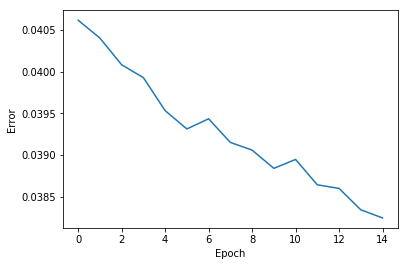

In [13]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()